# Onc vs chRCC with hyperparameter tuning

Code slightly altered from xgboost.ipynb, which trains the main XGBoost model.



In [1]:
path='../'

### First make sample number barplots

In [142]:
to_plot = diagnoses
to_plot['Source'] = ''
to_plot['Source'][to_plot['colname'].str.contains('_R')] = 'Chopra train' # Chopra train
to_plot['Source'][to_plot['colname'].str.contains('TCGA')] = 'TCGA' # TCGA
to_plot['Source'][np.logical_not(to_plot['colname'].str.contains('TCGA|_R'))] = 'Cambridge' # Cambridge
to_plot = to_plot[['pooled_labels', 'Source']]
to_plot
to_plot = to_plot.value_counts().reset_index()
to_plot

/home/in268/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/in268/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/in268/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

,pooled_labels,Source
60,3.0,Chopra train
61,3.0,Chopra train
62,3.0,Chopra train
63,3.0,Chopra train
64,3.0,Chopra train
...,...,...
1254,3.0,Cambridge
1255,2.0,Cambridge
1257,2.0,Cambridge
1260,2.0,Cambridge


,pooled_labels,Source,0
0,2.0,TCGA,66
1,2.0,Cambridge,27
2,3.0,Cambridge,21
3,3.0,Chopra train,7


/home/in268/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/in268/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/in268/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Th

,pooled_labels,Source,0
0,2.0,TCGA,66
1,3.0,Chopra train,37
2,2.0,Cambridge,27
3,3.0,Cambridge,21


2.0    93
3.0    58
Name: pooled_labels, dtype: int64

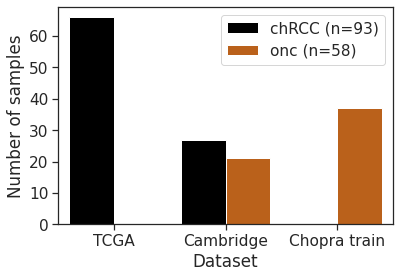

pathology
2    14
3    38
Name: count, dtype: int64

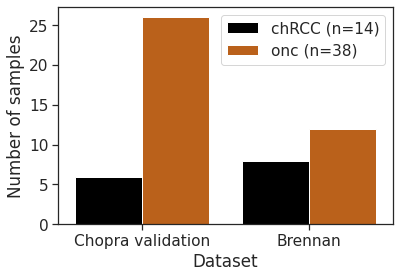

In [146]:
# do sample number barplot split by dataset
diagnoses = pd.read_csv(path+'data/training_testing_diagnoses_maxgap_50_newdata.csv', sep = ',')
diagnoses = diagnoses.iloc[2:, ] # remove two redundant rows
diagnoses.loc[:, 'pooled_labels'] = [4 if d == 5 else d for d in diagnoses['overallpath']] # pool the papilary types
diagnoses = diagnoses[diagnoses['overallpath'].isin([2, 3])]

to_plot = diagnoses
to_plot['Source'] = ''
to_plot['Source'][to_plot['colname'].str.contains('_R')] = 'Chopra train' # Chopra train
to_plot['Source'][to_plot['colname'].str.contains('TCGA')] = 'TCGA' # TCGA
to_plot['Source'][np.logical_not(to_plot['colname'].str.contains('TCGA|_R'))] = 'Cambridge' # Cambridge
to_plot = to_plot[['pooled_labels', 'Source']]

to_plot = to_plot.value_counts().reset_index()

to_plot

import matplotlib.pyplot as plt
import seaborn as sb
sb.set(font_scale=1.4) 
sb.set_style("ticks")

bp = sb.barplot(data = to_plot, x = 'Source', order=['TCGA', 'Cambridge', 'Chopra train'], y=0, hue = 'pooled_labels', palette = ["#000000", "#D55E00"])

# get legend labels with the total number of samples per class:
ns = diagnoses['pooled_labels'].value_counts()
ns
labels_with_ns = ['chRCC (n=' + str(ns.loc[2]) + ')',
                  'onc (n=' + str(ns.loc[3]) + ')'
                 ]

yl = plt.ylabel('Number of samples')
xl = plt.xlabel('Dataset')
handles = bp.get_legend_handles_labels()[0]
bp.legend(handles = handles, labels=labels_with_ns)#, loc='best', bbox_to_anchor=(0.7, -0.05, 0.25, 1))

plt.savefig('figs_hyperparameter_tuning/number_of_samples_barplot_separate_datasets.svg', bbox_inches='tight')
plt.show()

# now for external validation barplot:

diagnoses_chopra = pd.read_csv(path+'data/Chopra_external/preprocessed_validation_pdata.testing_diagnoses.csv')
mapping = {'Normal': 0, 'KIRC': 1, 'KICH': 2, 'oncocytoma': 3, 'KIRP': 4, 'normal': 0, 'Other': 5}
diagnoses_chopra['overallpath'] = [mapping[l] for l in diagnoses_chopra['label']]
diagnoses_chopra = diagnoses_chopra[diagnoses_chopra['overallpath'].isin([2, 3])]

diagnoses_brennan = pd.read_csv(path+'data/Brennandata/preprocessed_validation_diagnoses.csv')
mapping = {'Normal kidney parenchyma': 0, 'Clear cell RCC': 1, 'RCC-Chromophobe': 2, 'Oncocytoma': 3}
diagnoses_brennan['overallpath'] = [mapping[l] for l in diagnoses_brennan['Sample_Type']]
diagnoses_brennan = diagnoses_brennan[diagnoses_brennan['overallpath'].isin([2, 3])]

diagnoses_chopra = pd.DataFrame(diagnoses_chopra['overallpath'].value_counts())
diagnoses_chopra['Source'] = 'Chopra validation'
diagnoses_brennan = pd.DataFrame(diagnoses_brennan['overallpath'].value_counts())
diagnoses_brennan['Source'] = 'Brennan'


to_plot = diagnoses_chopra.append(diagnoses_brennan)
to_plot['pathology'] = to_plot.index
to_plot.columns = ['count', 'Source', 'pathology']

# get labels for legend that give number of samples in each class
ns = to_plot.groupby('pathology').sum()['count']
ns
labels_with_ns = ['chRCC (n=' + str(ns.loc[2]) + ')',
                  'onc (n=' + str(ns.loc[3]) + ')'
                 ]

import matplotlib.pyplot as plt
import seaborn as sb
bp = sb.barplot(data = to_plot, x = 'Source', y= 'count', hue = 'pathology', palette = [ "#000000", "#D55E00"])
           
yl = plt.ylabel('Number of samples')
xl = plt.xlabel('Dataset')
handles = bp.get_legend_handles_labels()[0]
bp.legend(handles = handles, labels=labels_with_ns, loc='upper right')#, bbox_to_anchor=(0.28, 0., 0.25, 1))

plt.savefig('validation_results/number_of_samples_barplot.svg', bbox_inches='tight')


### Data and training functions

In [2]:
import pandas as pd
import numpy as np

# returns data and labels, ready to be put into a model
# for now, generates dummy data
def get_data():
    # read in diagnoses and get pooled_labels and patient ids
    diagnoses = pd.read_csv(path+'data/training_testing_diagnoses_maxgap_50_newdata.csv', sep = ',')
    
    beta_array = pd.read_csv(path+'data/training_testing_maxgap_50_newdata.csv')
    seqnames = beta_array['seqnames']
    start = beta_array['start']
    colnames = beta_array.columns[2:]
    raw_data = np.array(beta_array.iloc[:, 2:])
    raw_data = np.transpose(raw_data)
                      
    return(raw_data, seqnames, start, colnames, diagnoses)

# getting dummy data: (if you want to test things, this data is very quick to run)
def get_dummy_data():
    # read in diagnoses and get pooled_labels and patient ids
    diagnoses = pd.read_csv(path+'data/training_testing_diagnoses_maxgap_50_newdata.csv', sep = ',')
    
    # create raw data between 0 and 1: (like beta value)
    means = diagnoses.iloc[2:]['overallpath']
    raw_data = [np.random.normal(mean/10, 0.05, 10) for mean in means]
    raw_data = np.abs(raw_data)
    raw_data = np.array([[1 if n > 1 else n for n in r] for r in raw_data])
    
    return(raw_data, diagnoses)

In [3]:
def preproc_diagnoses(diagnoses):
    diagnoses = diagnoses.iloc[2:, ] # remove two redundant rows
    diagnoses.loc[:, 'pooled_labels'] = [4 if d == 5 else d for d in diagnoses['overallpath']] # pool the papilary types
    
    diagnoses.loc[:, 'patient_id'] = list(map(lambda s: s[0], diagnoses['colname'].str.split('.'))) # get before '.' for all samples
    diagnoses.loc[:, 'patient_id'] = np.where(diagnoses['colname'].str.contains('TCGA|R'), np.nan, diagnoses['patient_id']) # filter out TCGA and chopra
    # replace nans with unique ids:
    unique_ids = range(diagnoses['patient_id'].isna().sum()) # in integers
    diagnoses.loc[diagnoses['patient_id'].isna(), 'patient_id'] = unique_ids
    
    labels = np.array(diagnoses['pooled_labels']).astype('int')
    
    # create names for the 5 classes
    class_mapping = {0:'normal', 1:'ccRCC', 2:'chRCC', 3:'onc', 4:'prccT1andT2'}
    classes = [0,1,2,3,4]
    classes = [class_mapping[l] for l in classes]
    
    return(diagnoses, labels, classes)

In [4]:
# given m values, removes Inf and -Inf which are caused by a beta value of 1 and 0
def deal_with_Inf(m_values_mat):
    # I will set -Inf to the min value and Inf to the max value
    # I did want to set it to the min and max possible value, but this causes overflow errors
    max_val = np.nanmax(m_values_mat[np.logical_not(np.isinf(m_values_mat))]) # looking at m values that arn't Inf
    min_val = np.nanmin(m_values_mat[np.logical_not(np.isinf(m_values_mat))]) 
    
    print('min and max vals are ', min_val, max_val)
    indices = np.argwhere(np.isinf(m_values_mat)) # where m values is +/- Inf
    for i in range(len(indices)):
        if m_values_mat[indices[i][0], indices[i][1]] > 0:
            m_values_mat[indices[i][0], indices[i][1]] = max_val
        else:
            m_values_mat[indices[i][0], indices[i][1]] = min_val
    return m_values_mat


# turn beta values into m values, deal with infinite values
def preproc_data(data, seqnames, start, colnames):
    # turn into m values
    m_vals = np.log2((data)/(1-data)) # this will result in inf and -infs!
    
    # deal with infinite values
    m_vals = deal_with_Inf(m_vals)
    
    print('mean of data is ', np.nanmean(m_vals))
    
    return(m_vals)
    

In [5]:
# gets train and test arrays and labels
# assumes data is a numpy array
def get_train_test(data, labels, train_indices, test_indices):
    train_x = data[train_indices, :]
    test_x = data[test_indices, :]
    train_y = labels[train_indices]
    test_y = labels[test_indices]
    return(train_x, test_x, train_y, test_y)


In [6]:
# functions to save xgboost evaluation results when training (called in function objective)
import os
def get_evals_result_name():
    nums = set(os.listdir('figs_hyperparameter_tuning/evals_results/')) - set(['.ipynb_checkpoints'])
    if nums == set():
        return('1')
    nums = [int(n) for n in nums]
    name = max(nums) + 1
    return(str(name))

import matplotlib.pyplot as plt
def plot_losses(losses, name):
    train_losses = losses['validation_0']['mlogloss']
    test_losses = losses['validation_1']['mlogloss']
    plt.figure(figsize = (10, 10))
    train_h = plt.scatter(range(len(train_losses)), train_losses, s = 1)
    test_h = plt.scatter(range(len(test_losses)), test_losses, s = 1)
    plt.legend(handles = [train_h, test_h], labels = ['train', 'test'])


In [7]:
# I tried 0.1 noise, but it wasn't enough to stop a perfect train score.
def add_noise(data, var = 0.2):
    noise = np.random.normal(0, var, data.shape)
    m_vals_with_noise = data + noise
    return(m_vals_with_noise)

In [8]:
# given some params, does the inner cross validation and returns the mean loss over all folds
import xgboost as xgb
from sklearn.metrics import log_loss, matthews_corrcoef
import pickle
def objective(params, train_x, train_y, inner_folds, train_weights):
    
    print('params is', params)
    
    losses = []
    for inner_train_indices, inner_test_indices in inner_folds: # loop through inner folds
        inner_train_x, inner_test_x, inner_train_y, inner_test_y = get_train_test(train_x, train_y, inner_train_indices, inner_test_indices) 
        inner_train_weights = train_weights[inner_train_indices]
        
        # add noise to training data
        inner_train_x = add_noise(inner_train_x)

        # subset so just chRCC and onc
        samples_to_take = np.isin(inner_train_y, [2, 3])
        inner_train_x = inner_train_x[samples_to_take]
        inner_train_y=inner_train_y[samples_to_take]
        inner_train_weights=inner_train_weights[samples_to_take]
        
        samples_to_take_test = np.isin(inner_test_y, [2, 3])
        inner_test_x=inner_test_x[samples_to_take_test]
        inner_test_y=inner_test_y[samples_to_take_test]
        
        # also put labels in 0, 1 format (rather than 2, 3)
        inner_train_y = (inner_train_y - 2).astype(int)
        inner_test_y = (inner_test_y - 2).astype(int)
        
        # train xgboost on inner train
        model = xgb.XGBClassifier(**params, objective = 'binary:logistic', subsample = 0.5, colsample_bytree = 0.5)
        early_stopping_num = 5 # with early stopping
        model.fit(inner_train_x, inner_train_y, sample_weight = inner_train_weights, eval_set=[(inner_train_x, inner_train_y), (inner_test_x, inner_test_y)], eval_metric=['logloss'], early_stopping_rounds = early_stopping_num)
        
        # test model on inner test
        predictions = model.predict(inner_test_x)
        print('predictions are ', predictions)
        # return scores
        mcc = matthews_corrcoef(inner_test_y, predictions)
        print('mcc is', mcc)
        
        losses.append(1-mcc)
        
        # print('fit a model')
    print('Average loss (1-mcc) is ', np.mean(losses), ' for params ', str(params))
    
    return(np.mean(losses))

    

In [9]:

def retrain(params, train_x, train_y, train_weights):
    params['n_estimators'] = int(params['n_estimators']) # need to be cast to int
    params['max_depth'] = int(params['max_depth'])
    
    # add noise to training data
    train_x = add_noise(train_x)
    
    samples_to_take = np.isin(train_y, [2, 3])
    train_x = train_x[samples_to_take]
    train_y=train_y[samples_to_take]
    train_weights=train_weights[samples_to_take]
    train_y = (train_y - 2).astype(int) # also put labels in 0, 1 format (rather than 2, 3)
    
    best_model = xgb.XGBClassifier(**params, objective = 'binary:logistic', subsample = 0.5, colsample_bytree = 0.5)
    best_model.fit(train_x, train_y, sample_weight = train_weights)
    return(best_model)

In [10]:
import pickle
import joblib
import os
# take all results from one outer fold, and all storage lists, and put them in the lists 
def append_results(i, best, best_params, bayes_trials, bayes_trials_hist, best_model, best_models, test_indices, test_indices_list):
    best_params.append(best)
    bayes_trials_hist.append(bayes_trials)
    best_models.append(best_model)
    test_indices_list.append(test_indices)
    
    # saving arrays. Will overwrite previous outerfolds so the saved version is always the latest version
    pickle.dump(best_params, open('figs_hyperparameter_tuning/best_params.json', 'wb'))
    pickle.dump(bayes_trials_hist, open('figs_hyperparameter_tuning/bayes_trials_hist.json', 'wb'))
    pickle.dump(test_indices_list, open('figs_hyperparameter_tuning/test_indices_list.json', 'wb'))
    
    # saving latest model - make the dir if necessary and save latest model 
    if not ('xgboost_models') in os.listdir('figs_hyperparameter_tuning/'):
        os.mkdir('figs_hyperparameter_tuning/xgboost_models')
    joblib.dump(best_model, 'figs_hyperparameter_tuning/xgboost_models' + '/' + str(i) + '.pkl')

    
    return(best_params, bayes_trials_hist, best_models, test_indices_list)

    

In [11]:
from sklearn.metrics import matthews_corrcoef, accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
import sys
sys.path.append('../')
from Evaluate import plot_curve
from Evaluate import plot_confusion_matrix

# adds a score object to scores, which contains many metrics. Also saves confusion matrices, and roc and pr curves
def append_scores(i, scores, test_y, test_predictions, test_predictions_prob, classes):
    score_object = {}
    
    score_object['mcc'] = matthews_corrcoef(test_y, test_predictions)
    score_object['acc'] = accuracy_score(test_y, test_predictions)
    score_object['f1'] = f1_score(test_y, test_predictions, average = None)
    score_object['conf_mat'] = confusion_matrix(test_y, test_predictions)
    score_object['precision'] = precision_score(test_y, test_predictions, average = None)
    score_object['recall'] = recall_score(test_y, test_predictions, average = None)
        
    # now plot pr and roc curves and save their areas
    print('classes is ', classes)
    colours = ["#D55E00", "#CCBB44"]
    roc_auc = plot_curve('roc', test_y, test_predictions_prob, len(classes), classes, colours, str(i), save_folder = 'figs_hyperparameter_tuning/figs/')
    pr_auc = plot_curve('precision_recall', test_y, test_predictions_prob, len(classes), classes, colours, str(i), save_folder = 'figs_hyperparameter_tuning/figs/')  
    score_object['roc_auc'] = roc_auc
    score_object['pr_auc'] = pr_auc
    
    scores.append(score_object)
    
    # and plotting confusion matrices
    plot_confusion_matrix(confusion_matrix(test_y, test_predictions), 'onc_vs_chRCC_hyperparamtuning', save_path = 'figs_hyperparameter_tuning/figs/confusion_matrix_' + str(i) + '.svg', font_size = 36, cm_labels = classes)
    if len(scores) == 4: # if we have done all iterations, save final summed confusion matrix
        conf_mats = [scores[i]['conf_mat'] for i in range(4)]
        plot_confusion_matrix(sum(conf_mats), 'onc_vs_chRCC_hyperparamtuning', save_path = 'figs_hyperparameter_tuning/figs/confusion_matrix_sum.svg', font_size = 36, cm_labels = classes)
        
    # now to save the scores
    pickle.dump(scores, open('figs_hyperparameter_tuning/scores.json', 'wb'))
    return(scores)
    

In [12]:
# make xgboost hyperparameter search space
from hyperopt import hp
import numpy as np
from hyperopt.pyll.base import scope
space = { # have restricted the n_estimators and max_depth to 500 and 5 to avoid overfitting
#     'class_weight': hp.choice('class_weight', [None, 'balanced']), # add in weights??
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 500, 1)),
    'eta': hp.loguniform('eta', np.log(0.05), np.log(0.5)),
    'max_depth': scope.int(hp.quniform('max_depth', 2, 3, 1)),
    'reg_alpha': hp.uniform('alpha', 0.0, 1.0), # L1 regularisation
    'reg_lambda': hp.uniform('lambda', 0.0, 1.0), # L2 regularisation
}


In [13]:
# setting it up to work in parallel
# this is set up for jupyter notebook, but it seems to work when running in a python3 script too
import os

# trying this guide: https://opensource.com/article/18/11/pyspark-jupyter-notebook
SPARK_HOME = "/home/in268/.local/lib/python3.7/site-packages/pyspark"
os.environ["SPARK_HOME"] = "/home/in268/.local/lib/python3.7/site-packages/pyspark"
os.environ["PYTHONPATH"]= SPARK_HOME + "/python"
os.environ["PYSPARK_DRIVER_PYTHON"] = "jupyter"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"] = "notebook"
os.environ['PYSPARK_PYTHON'] = 'python3'
os.environ['PATH'] = SPARK_HOME + ':' + os.environ['PATH'] + ':~/.local/bin:' + os.environ['JAVA_HOME'] + '/bin:' + os.environ['JAVA_HOME'] + '/jre/bin'

from pyspark.sql import SparkSession

# set max memory in spark sess
spark_sess = SparkSession.builder.master('local[2]').config("spark.driver.memory", "60g") .appName('my-cool-app').getOrCreate()



starting to set up


/home/in268/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/home/in268/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/in268/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

min and max vals are  -12.475986690870657 11.321364432039529
mean of data is  -2.2063126209584643


(1228, 158670)

Should be empty sets if no patient overlaps:
set()
set()
set()
set()


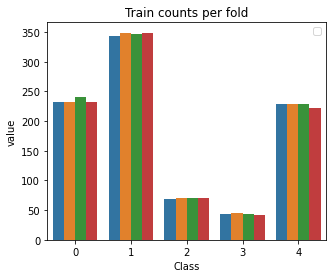

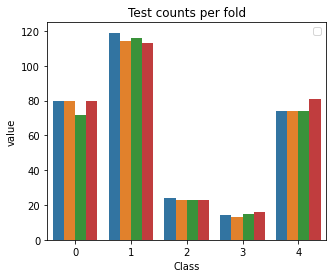

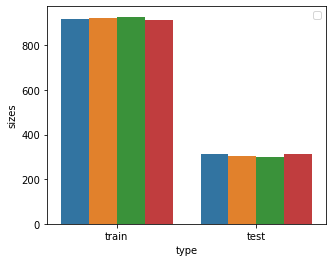

In [14]:
# set up and getting data and outer folds
from hyperopt import tpe, fmin, Trials, SparkTrials
from functools import partial
from get_train_weights import *
from get_folds import *

print('starting to set up')
tpe_algorithm = tpe.suggest # hyperopt optimisation algorithm

best_params = []
bayes_trials_hist = []
best_models = []
test_indices_list = []

scores = []

# get data and preprocess
data, seqnames, start, colnames, diagnoses = get_data()
diagnoses, labels, classes = preproc_diagnoses(diagnoses)
data = preproc_data(data, seqnames, start, colnames)

data.shape

outer_folds = get_folds(diagnoses, 4)
check_folds(diagnoses, outer_folds)
plot_split_barplots(labels, outer_folds)

all_test_predictions = np.array([np.nan]*len(labels))

In [15]:
data.shape

(1228, 158670)

In [16]:
# right do the outer folds have completely unique test sets?
print('Should be 3 empty sets:')
set(outer_folds[0][1]).intersection(outer_folds[1][1])
set(outer_folds[0][1]).intersection(outer_folds[2][1])
set(outer_folds[2][1]).intersection(outer_folds[3][1])


Should be 3 empty sets:


set()

set()

set()

(917, 100)

(311, 100)

should be 1 number in list:  [1.06912442]
should be 1 number in list:  [1.19512195 1.19512195]
should be 1 number in list:  [1.04545455]
should be 1 number in list:  [1.12820513]
should be 1 number in list:  [1.03153153 1.03153153]
[ True  True  True  True  True]
[ True  True  True  True  True]
True
True
should be 1 number per class:
[array([0.84516129]), array([0.63902439, 0.63902439, 0.63902439]), array([2.77878788]), array([4.7025641]), array([0.82612613])]
should be the same number for each class:
               combined_weight
pooled_labels                 
0.0                      183.4
1.0                      183.4
2.0                      183.4
3.0                      183.4
4.0                      183.4
Should be empty sets if no patient overlaps:
set()
set()
set()
set()


../get_train_weights.py:70: RuntimeWarning: Mean of empty slice
  c_1 = np.nanmean([res[0], res[1]], axis = 0)
../get_train_weights.py:71: RuntimeWarning: Mean of empty slice
  c_2 = np.nanmean([c_1, res[2]], axis = 0)
../get_train_weights.py:72: RuntimeWarning: Mean of empty slice
  c_3 = np.nanmean([c_2, res[3]], axis = 0)


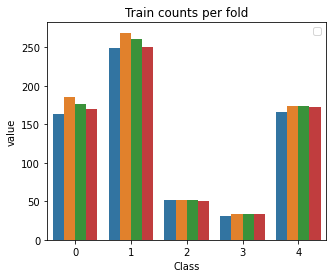

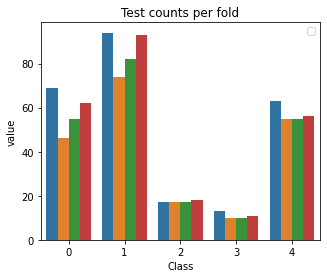

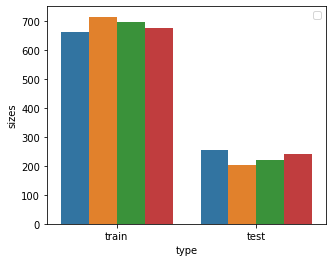

100%|██████████| 10/10 [00:11<00:00,  1.11s/trial, best loss: 0.24615929646301846]


Total Trials: 10: 10 succeeded, 0 failed, 0 cancelled.


classes is  ['chRCC', 'onc']


(924, 100)

(304, 100)

should be 1 number in list:  [1.07407407 1.07407407]
should be 1 number in list:  [1.20833333 1.20833333]
should be 1 number in list:  [1.06060606]
should be 1 number in list:  [1.125]
should be 1 number in list:  [1.03153153 1.03153153]
[ True  True  True  True  True]
[ True  True  True  True  True]
True
True
should be 1 number per class:
[array([0.85555556, 0.85555556]), array([0.64166667, 0.64166667]), array([2.8]), array([4.62]), array([0.83243243, 0.83243243])]
should be the same number for each class:
               combined_weight
pooled_labels                 
0.0                      184.8
1.0                      184.8
2.0                      184.8
3.0                      184.8
4.0                      184.8
Should be empty sets if no patient overlaps:
set()
set()
set()
set()


../get_train_weights.py:70: RuntimeWarning: Mean of empty slice
  c_1 = np.nanmean([res[0], res[1]], axis = 0)
../get_train_weights.py:71: RuntimeWarning: Mean of empty slice
  c_2 = np.nanmean([c_1, res[2]], axis = 0)
../get_train_weights.py:72: RuntimeWarning: Mean of empty slice
  c_3 = np.nanmean([c_2, res[3]], axis = 0)


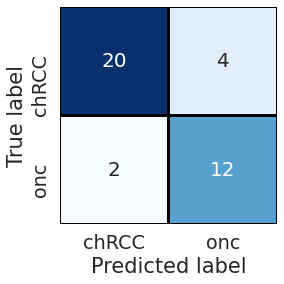

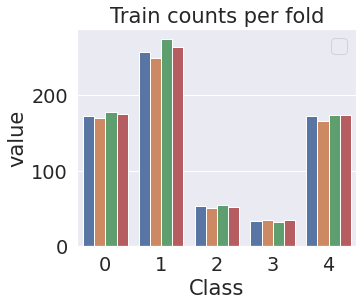

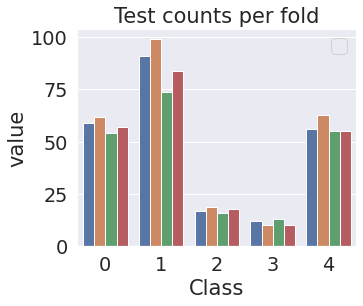

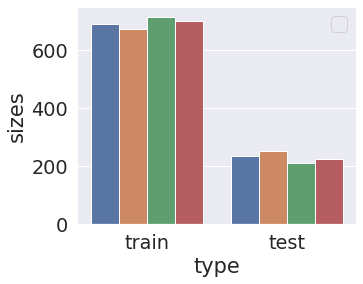

100%|██████████| 10/10 [00:11<00:00,  1.11s/trial, best loss: 0.2581250587357549]


Total Trials: 10: 10 succeeded, 0 failed, 0 cancelled.


classes is  ['chRCC', 'onc']


(928, 100)

(300, 100)

should be 1 number in list:  [1.07623318]
should be 1 number in list:  [1.20557491 1.20557491 1.20557491]
should be 1 number in list:  [1.06060606]
should be 1 number in list:  [1.075]
should be 1 number in list:  [1.03153153 1.03153153]
[ True  True  True  True  True]
[ True  True  True  True  True]
True
True
should be 1 number per class:
[array([0.832287]), array([0.6466899, 0.6466899, 0.6466899]), array([2.81212121, 2.81212121]), array([4.64]), array([0.83603604, 0.83603604])]
should be the same number for each class:
               combined_weight
pooled_labels                 
0.0                      185.6
1.0                      185.6
2.0                      185.6
3.0                      185.6
4.0                      185.6
Should be empty sets if no patient overlaps:
set()
set()
set()
set()


../get_train_weights.py:70: RuntimeWarning: Mean of empty slice
  c_1 = np.nanmean([res[0], res[1]], axis = 0)
../get_train_weights.py:71: RuntimeWarning: Mean of empty slice
  c_2 = np.nanmean([c_1, res[2]], axis = 0)
../get_train_weights.py:72: RuntimeWarning: Mean of empty slice
  c_3 = np.nanmean([c_2, res[3]], axis = 0)


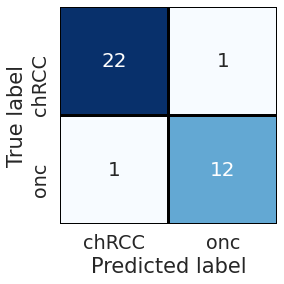

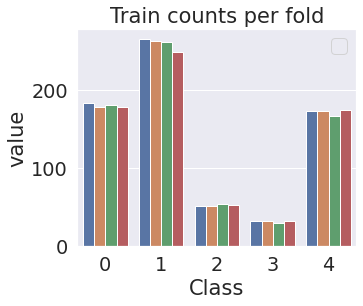

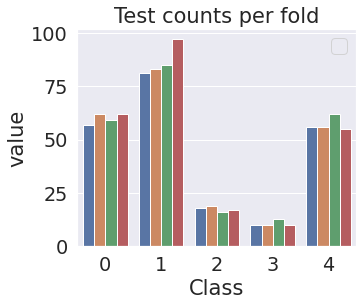

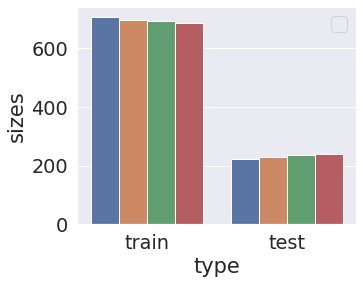

100%|██████████| 10/10 [00:11<00:00,  1.11s/trial, best loss: 0.17485146200478419]


Total Trials: 10: 10 succeeded, 0 failed, 0 cancelled.


classes is  ['chRCC', 'onc']


(915, 100)

(313, 100)

should be 1 number in list:  [1.08411215]
should be 1 number in list:  [1.21602787 1.21602787]
should be 1 number in list:  [1.06060606]
should be 1 number in list:  [1.05 1.05]
should be 1 number in list:  [1.]
[ True  True  True  True  True]
[ True  True  True  True  True]
True
True
should be 1 number per class:
[array([0.85514019, 0.85514019]), array([0.63763066, 0.63763066]), array([2.77272727, 2.77272727]), array([4.575, 4.575]), array([0.82432432])]
should be the same number for each class:
               combined_weight
pooled_labels                 
0.0                      183.0
1.0                      183.0
2.0                      183.0
3.0                      183.0
4.0                      183.0
Should be empty sets if no patient overlaps:
set()
set()
set()
set()


../get_train_weights.py:70: RuntimeWarning: Mean of empty slice
  c_1 = np.nanmean([res[0], res[1]], axis = 0)
../get_train_weights.py:71: RuntimeWarning: Mean of empty slice
  c_2 = np.nanmean([c_1, res[2]], axis = 0)
../get_train_weights.py:72: RuntimeWarning: Mean of empty slice
  c_3 = np.nanmean([c_2, res[3]], axis = 0)


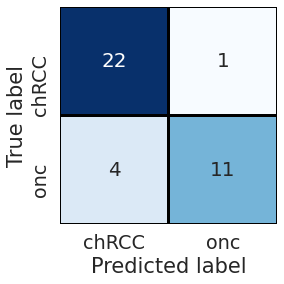

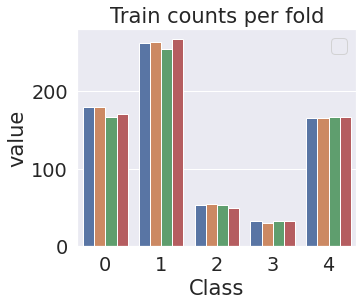

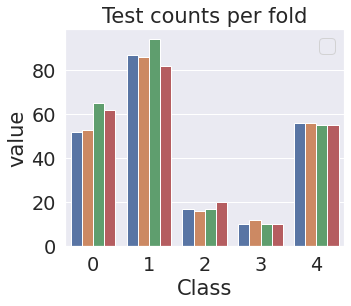

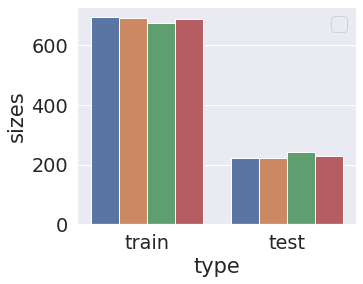

100%|██████████| 10/10 [00:11<00:00,  1.11s/trial, best loss: 0.2215366896876217]


Total Trials: 10: 10 succeeded, 0 failed, 0 cancelled.


classes is  ['chRCC', 'onc']


ValueError: cannot convert float NaN to integer

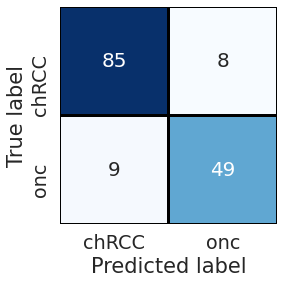

In [17]:
# train and test the models on the data, using nested cross validation and hyperopt for hyperparameter finding
i = 0
for train_indices, test_indices in outer_folds:
    
    train_x, test_x, train_y, test_y = get_train_test(data, labels, train_indices, test_indices)
    diagnoses_train = diagnoses.iloc[train_indices]
    
    # subset features to make smaller for when developing code
#     train_x = train_x[:,0:100]
#     test_x = test_x[:,0:100]
#     train_x.shape
#     test_x.shape

    # calculate training sample weights
    train_weights = get_weights(diagnoses_train.copy(deep = True))
    check_weights(train_weights) # can comment out if output is annoying
    train_weights = train_weights['combined_weight']
    
    # get inner folds and check them
    inner_folds = get_folds(diagnoses_train, 4)
    check_folds(diagnoses_train, inner_folds) # can comment these two checking functions if the output is annoying
    plot_split_barplots(train_y, inner_folds)

    # hyperopt function, which uses objective function
    bayes_trials_parallel = SparkTrials(parallelism=2, spark_session = spark_sess) 
    bayes_trials = Trials()
    fmin_objective = partial(objective, train_x=train_x, train_y = train_y, inner_folds = inner_folds, train_weights = train_weights) # make parital function with our non-standard arguments
    best = fmin(fn = fmin_objective, space = space, algo = tpe.suggest, 
            max_evals = 10, trials = bayes_trials_parallel)
    
    # retrain model over all of x_train with best params (we subset chRCC and onc within this function)
    best_model = retrain(best, train_x, train_y, train_weights)
    
    # subset test data so it is just chRCC and onc 
    samples_to_take = np.isin(test_y, [2, 3])
    test_x = test_x[samples_to_take]
    test_y=test_y[samples_to_take]
    test_y = (test_y - 2).astype(int) # also put labels in 0, 1 format (rather than 2, 3)
    test_indices = test_indices[samples_to_take]
    classes = ['chRCC', 'onc']
    
    # save model
    best_params, bayes_trials_hist, best_models, test_indices_list = append_results(i = i, best = best, best_params = best_params, bayes_trials = bayes_trials, bayes_trials_hist = bayes_trials_hist, best_model = best_model, best_models = best_models, test_indices = test_indices, test_indices_list = test_indices_list)
    
    # make predictions 
    test_predictions = best_model.predict(test_x)
    test_predictions_prob = best_model.predict_proba(test_x)
    all_test_predictions[test_indices] = test_predictions
    
    # save scores
    scores = append_scores(i, scores, test_y, test_predictions, test_predictions_prob, classes)
    
    i = i + 1
    

# and finally save all test predictions
all_test_predictions = all_test_predictions.astype(str)
all_test_predictions[all_test_predictions=='nan'] = '' # deal with nans
np.savetxt('figs_hyperparameter_tuning/all_test_predictions', all_test_predictions, delimiter=",", fmt="%s")


### Reading in models and results

In [22]:
# reading in models after they have been saved
import pickle
import joblib

def read_models():
        
    models = []
    for i in range(4):
        model = joblib.load('figs_hyperparameter_tuning/xgboost_models/' + str(i) + '.pkl')
        models.append(model)
        
    # now load the other arrays
    test_indices_list = pickle.load(open('figs_hyperparameter_tuning/test_indices_list.json', 'rb'))
    best_params = pickle.load(open('figs_hyperparameter_tuning/best_params.json', 'rb'))
    bayes_trials_hist = pickle.load(open('figs_hyperparameter_tuning/bayes_trials_hist.json', 'rb'))
    
    return(models, test_indices_list, best_params, bayes_trials_hist)


# models, test_indices_list, best_params, bayes_trials_hist = read_models()


In [2]:
# loading scores:
import pickle
import numpy as np
scores = pickle.load(open('figs_hyperparameter_tuning/scores.json', 'rb'))
scores

np.mean([s['acc'] for s in scores]) # average accuracy
np.mean([s['mcc'] for s in scores]) # average MCC
np.mean([s['roc_auc'][0] for s in scores]) # average ROC AUC (we can average ROC AUC here as binary classification so only one ROC AUC per model)


[{'mcc': 0.8464861424907173,
  'acc': 0.925,
  'f1': array([0.93617021, 0.90909091]),
  'conf_mat': array([[22,  1],
         [ 2, 15]]),
  'precision': array([0.91666667, 0.9375    ]),
  'recall': array([0.95652174, 0.88235294]),
  'roc_auc': array([0.98976982, 0.98976982]),
  'pr_auc': [0.9934349064783846, 0.985206925907618]},
 {'mcc': 0.9421114395319916,
  'acc': 0.9736842105263158,
  'f1': array([0.98039216, 0.96      ]),
  'conf_mat': array([[25,  0],
         [ 1, 12]]),
  'precision': array([0.96153846, 1.        ]),
  'recall': array([1.        , 0.92307692]),
  'roc_auc': array([0.99384615, 0.99384615]),
  'pr_auc': [0.9967974358974361, 0.9893772893772892]},
 {'mcc': 0.9396505434536336,
  'acc': 0.9714285714285714,
  'f1': array([0.97777778, 0.96      ]),
  'conf_mat': array([[22,  0],
         [ 1, 12]]),
  'precision': array([0.95652174, 1.        ]),
  'recall': array([1.        , 0.92307692]),
  'roc_auc': array([1., 1.]),
  'pr_auc': [0.9999999999999998, 0.999999999999999

0.9675281954887218

0.9320620313690856

0.9959039937045052

### External validation

In [102]:
# load external validation datasets (just Chopra and Brennan - Wei and Evelonn don't have chRCC or onc samples)

# load Chopra data
import pandas as pd
data_chopra = pd.read_csv(path+'data/Chopra_external/preprocessed_validation_m_vals.csv')
diagnoses_chopra = pd.read_csv(path+'data/Chopra_external/preprocessed_validation_pdata.testing_diagnoses.csv')
mapping = {'Normal': 0, 'KIRC': 1, 'KICH': 2, 'oncocytoma': 3, 'KIRP': 4, 'normal': 0, 'Other': 5}

seqnames = data_chopra['seqnames']
start = data_chopra['start']
colnames = data_chopra.columns[3:]

diagnoses_chopra['overallpath'] = [mapping[l] for l in diagnoses_chopra['label']]
diagnoses_chopra
(data_chopra.columns[3:] == 'X' + diagnoses_chopra['id']).mean() # diagnoses in same order as columns

# put in numpy array and transpose:
data_chopra = np.transpose(np.array(data_chopra.iloc[:,3:]))

# only take chRCC and onc samples
indices_to_take = diagnoses_chopra['overallpath'].isin([2, 3])
diagnoses_chopra = diagnoses_chopra[indices_to_take]
diagnoses_chopra['overallpath'] = diagnoses_chopra['overallpath'] - 2 # turn 2, 3 labels into 0, 1 to match the model's class labelling
data_chopra = data_chopra[indices_to_take]

diagnoses_chopra
diagnoses_chopra.shape
diagnoses_chopra['overallpath'].value_counts()
data_chopra
data_chopra.shape


,Unnamed: 0,label,id,overallpath
0,1,Normal,8784241029_R01C01,0
1,2,KIRC,8784241029_R02C01,1
2,3,KIRC,8784241029_R03C01,1
3,4,Normal,8784241029_R04C01,0
4,5,KIRC,8784241029_R05C01,1
...,...,...,...,...
240,267,KIRP,8795194001_R06C02,4
241,268,KIRP,8795194002_R01C01,4
242,269,Normal,8795194089_R05C01,0
243,270,KIRC,8795194089_R06C01,1


1.0

/home/in268/.local/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Unnamed: 0,label,id,overallpath
14,17,oncocytoma,8784241087_R01C01,1
29,32,oncocytoma,8795194005_R06C01,1
31,34,oncocytoma,8795194005_R02C02,1
32,35,oncocytoma,8795194005_R03C02,1
37,40,KICH,8795194049_R02C01,0
38,41,KICH,8795194049_R03C01,0
42,45,oncocytoma,8795194049_R01C02,1
43,46,oncocytoma,8795194049_R02C02,1
68,77,oncocytoma,8795194001_R04C01,1
69,78,oncocytoma,8795194001_R05C01,1


(32, 4)

1    26
0     6
Name: overallpath, dtype: int64

array([[-0.16859856,  3.83752725, -3.98879652, ..., -5.17040767,
        -5.61002966, -3.77690001],
       [-1.34157643,  3.75393712, -3.81518876, ..., -2.84982435,
        -2.29464823, -3.13574441],
       [-0.90774669,  3.9640101 , -3.62782251, ..., -4.38464078,
        -3.86539046, -2.50124504],
       ...,
       [-2.25908652,  3.47076093, -3.91661151, ..., -5.75142096,
        -5.24830429, -5.43311803],
       [-2.66921393,  4.49017095, -4.18855251, ..., -4.5540919 ,
        -5.33244467, -4.40144615],
       [ 0.20039436,  4.14536869, -3.71715206, ..., -4.9340945 ,
        -4.80717199, -2.02933735]])

(32, 158670)

In [103]:
# load Brennan data
import pandas as pd
data_brennan = pd.read_csv(path+'data/Brennandata/preprocessed_validation_m_vals.csv')
data_brennan

seqnames = data_brennan['seqnames']
start = data_brennan['start']
colnames = data_brennan.columns[3:]

diagnoses_brennan = pd.read_csv(path+'data/Brennandata/preprocessed_validation_diagnoses.csv')
mapping = {'Normal kidney parenchyma': 0, 'Clear cell RCC': 1, 'RCC-Chromophobe': 2, 'Oncocytoma': 3}
diagnoses_brennan['overallpath'] = [mapping[l] for l in diagnoses_brennan['Sample_Type']]

(data_brennan.columns[3:] == 'X' + diagnoses_brennan['X']).mean() # diagnoses in same order as columns

# put in numpy array and transpose:
data_brennan = np.transpose(np.array(data_brennan.iloc[:,3:]))

# only take chRCC and onc samples
indices_to_take = diagnoses_brennan['overallpath'].isin([2, 3])
diagnoses_brennan = diagnoses_brennan[indices_to_take]
diagnoses_brennan['overallpath'] = diagnoses_brennan['overallpath'] - 2 # turn 2, 3 labels into 0, 1 to match the model's class labelling
data_brennan = data_brennan[indices_to_take]

diagnoses_brennan
diagnoses_brennan.shape
diagnoses_brennan['overallpath'].value_counts()
data_brennan
data_brennan.shape

/home/in268/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,seqnames,start,X200397540076_R01C01,X200397540076_R02C01,X200397540076_R03C01,X200397540076_R04C01,X200397540076_R05C01,X200397540076_R06C01,X200397540076_R01C02,...,X200397540095_R04C01,X200397540095_R05C01,X200397540095_R06C01,X200397540095_R02C02,X200397540095_R04C02,X200397540095_R06C02,X200394970099_R01C01,X200394970099_R02C01,X200394970099_R03C01,X200394970099_R04C01
0,0,16,53434200,-2.410453,-0.578894,-0.677115,-0.158265,0.371911,-0.204119,-2.838735,...,-1.807547,-0.117592,-0.368004,-0.442526,-0.389406,-0.485664,-0.369154,0.193851,1.277104,0.052621
1,1,6,25282551,4.129704,3.660669,3.432851,3.407971,3.212938,3.376535,3.683546,...,3.754500,3.579304,3.917513,3.525948,3.623678,3.338777,3.621265,3.939203,3.978525,3.808664
2,2,3,129183534,-3.673265,-3.708390,-3.856591,-3.809850,-3.446806,-3.675274,-3.519044,...,-3.932931,-3.537837,-3.717203,-3.713104,-3.706082,-3.689242,-4.153712,-3.780349,-4.051145,-3.940932
3,3,12,123601930,-4.021386,-3.857981,-4.230512,-3.831333,-4.107561,-4.255137,-3.729211,...,-3.798526,-3.881928,-4.001825,-4.127378,-4.009893,-4.153360,-3.942944,-4.710243,-4.217106,-4.565820
4,4,15,59493107,-3.584482,-3.907965,-3.700879,-4.138469,-3.596958,-3.896326,-3.538724,...,-3.720414,-3.992819,-4.050417,-3.702919,-4.148852,-3.920989,-3.616875,-3.963970,-4.199160,-4.287580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158665,158665,2,227460160,-4.947927,-4.112420,-5.749383,-4.805810,-6.168768,-3.957192,-5.898936,...,-5.549222,-5.554545,-5.242586,-6.205258,-4.077343,-4.925744,-14.447212,-14.447212,-8.343115,-4.156953
158666,158666,2,47206143,-3.242523,-1.553299,-3.537180,-1.930454,-4.593313,-1.364972,-3.532724,...,-3.820834,-2.857408,-2.700132,-4.034783,-1.434667,-1.695359,-5.704586,-4.761812,-4.930239,-1.778788
158667,158667,2,65612270,-4.685872,-4.643706,-5.236226,-4.223567,-5.250722,-3.893258,-5.174308,...,-5.253506,-5.581381,-4.603669,-5.218599,-3.847272,-4.269114,-7.001730,-5.931557,-5.648022,-4.264667
158668,158668,7,22665906,-4.878609,-4.709102,-5.590051,-5.498680,-5.345451,-4.698470,-4.951359,...,-5.378853,-4.771209,-4.574654,-5.341521,-5.032849,-5.114496,-6.735307,-6.464342,-5.939448,-5.375838


1.0

,Unnamed: 0,X,Sample_Type,overallpath
0,1,200397540076_R01C01,Oncocytoma,1
2,3,200397540076_R03C01,Oncocytoma,1
4,5,200397540076_R05C01,Oncocytoma,1
6,7,200397540076_R01C02,RCC-Chromophobe,0
8,9,200397540076_R03C02,RCC-Chromophobe,0
10,11,200397540076_R05C02,RCC-Chromophobe,0
12,13,200397540082_R01C01,Oncocytoma,1
14,15,200397540082_R03C01,Oncocytoma,1
16,17,200397540082_R05C01,Oncocytoma,1
18,19,200397540082_R01C02,RCC-Chromophobe,0


(20, 4)

1    12
0     8
Name: overallpath, dtype: int64

array([[ -2.41045349,   4.12970443,  -3.6732651 , ...,  -4.68587172,
         -4.87860855,  -5.57814967],
       [ -0.67711457,   3.43285103,  -3.85659065, ...,  -5.23622619,
         -5.59005142,  -5.04139492],
       [  0.37191112,   3.21293839,  -3.44680607, ...,  -5.2507217 ,
         -5.34545143,  -5.03268355],
       ...,
       [ -0.44252565,   3.52594815,  -3.7131038 , ...,  -5.21859867,
         -5.34152061,  -5.33820935],
       [ -0.36915394,   3.62126506,  -4.15371177, ...,  -7.00173019,
         -6.73530697,  -5.02244658],
       [  0.19385097,   3.93920297,  -3.78034858, ...,  -5.93155689,
         -6.46434214, -14.4472124 ]])

(20, 158670)

(32, 2)

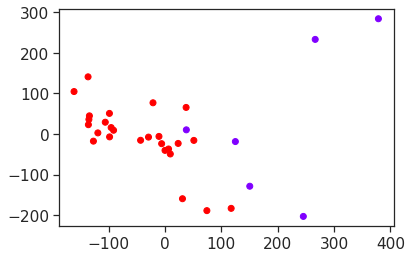

(20, 2)

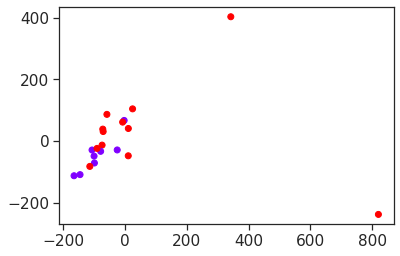

In [104]:
# PCA both datasets to check they look roughly correct

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embedding=pca.fit_transform(np.nan_to_num(data_chopra))
embedding.shape
import matplotlib.pyplot as plt
s = plt.scatter(embedding[:,0], embedding[:,1], c=diagnoses_chopra['overallpath'], cmap='rainbow')
plt.show()

pca = PCA(n_components=2)
embedding=pca.fit_transform(np.nan_to_num(data_brennan))
embedding.shape
import matplotlib.pyplot as plt
s = plt.scatter(embedding[:,0], embedding[:,1], c=diagnoses_brennan['overallpath'], cmap='rainbow')



In [105]:
def get_model(i):
    import joblib
    model = joblib.load('figs_hyperparameter_tuning/xgboost_models/' + str(i) + '.pkl')
    return(model)

Accuracies are [0.1875, 0.1875, 0.1875, 0.1875]
Average acc is  0.1875
Average ROC AUC for each class: 


,ROC AUC
chRCC,0.730769
oncocytoma,0.730769


Average PR AUC for each class: 


,PR AUC
chRCC,0.472417
oncocytoma,0.918143


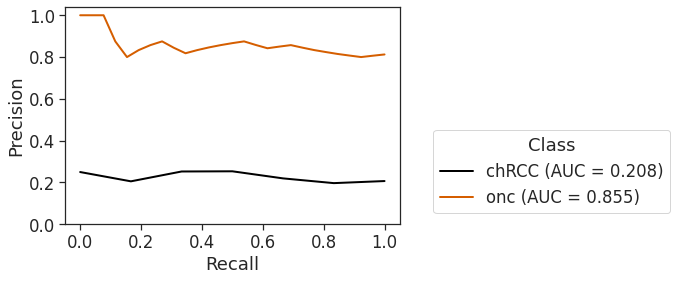

In [106]:
# Chopra results

from sklearn.metrics import confusion_matrix
from Evaluate import plot_curve, plot_confusion_matrix
# now we can predict with each model
accs = []
roc_aucs = []
pr_aucs = []
for model_num in range(4):

    model=get_model(model_num)

    predictions = model.predict(data_chopra)
    probs = model.predict_proba(data_chopra)

    acc = (diagnoses_chopra['overallpath'] == predictions).mean()
    accs. append(acc)

    cm_labels = ['chRCC', 'onc']
    plot_confusion_matrix(confusion_matrix(diagnoses_chopra['overallpath'], predictions), 'xgboost_onc_vs_chRCC', save_path = 'figs_hyperparameter_tuning/validation_results/chopra_confusion_matrix_' + str(model_num) + '.svg', font_size = 36, cm_labels = cm_labels)

    colours = ["#000000", "#D55E00"]
    roc_auc = plot_curve('roc', diagnoses_chopra['overallpath'], probs, len(cm_labels), cm_labels, colours, str(model_num), save_folder = 'figs_hyperparameter_tuning/validation_results/chopra_')
    roc_aucs.append(roc_auc)

    pr_auc = plot_curve('precision_recall', diagnoses_chopra['overallpath'], probs, len(cm_labels), cm_labels, colours, str(model_num), save_folder = 'figs_hyperparameter_tuning/validation_results/chopra_')
    pr_aucs.append(pr_auc)

print('Accuracies are', accs)
print('Average acc is ', np.mean(accs))
print('Average ROC AUC for each class: ')
pd.DataFrame(np.mean(roc_aucs, axis = 0), index = ['chRCC', 'oncocytoma'], columns = ['ROC AUC'])

print('Average PR AUC for each class: ')
pd.DataFrame(np.mean(pr_aucs, axis = 0), index = ['chRCC', 'oncocytoma'], columns = ['PR AUC'])


In [107]:
roc_aucs
pr_aucs

[array([0.87179487, 0.87179487]),
 array([0.83333333, 0.83333333]),
 array([0.6474359, 0.6474359]),
 array([0.57051282, 0.57051282])]

[[0.6614748677248676, 0.969270960921282],
 [0.6277824912016088, 0.9581325290225693],
 [0.39289234730411204, 0.8903505899511694],
 [0.2075194185014275, 0.8548197691839848]]

Accuracies are [0.4, 0.4, 0.4, 0.4]
Average acc is  0.4
Average ROC AUC for each class: 


,ROC AUC
chRCC,0.953125
oncocytoma,0.953125


Average PR AUC for each class: 


,PR AUC
chRCC,0.929909
oncocytoma,0.972574


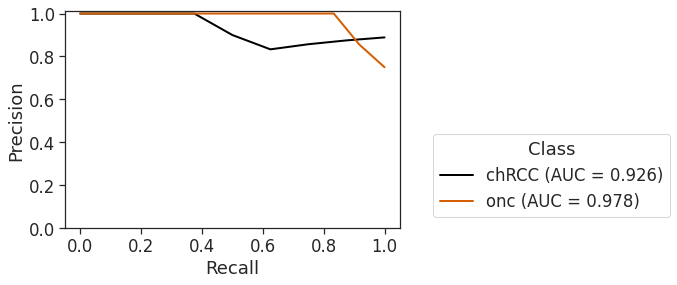

In [108]:
# Brennan results

from sklearn.metrics import confusion_matrix
from Evaluate import plot_curve, plot_confusion_matrix
# now we can predict with each model
accs = []
roc_aucs = []
pr_aucs = []
for model_num in range(4):

    model=get_model(model_num)

    predictions = model.predict(data_brennan)
    probs = model.predict_proba(data_brennan)

    acc = (diagnoses_brennan['overallpath'] == predictions).mean()
    accs.append(acc)

    cm_labels = ['chRCC', 'onc']
    plot_confusion_matrix(confusion_matrix(diagnoses_brennan['overallpath'], predictions), 'xgboost_onc_vs_chRCC', save_path = 'figs_hyperparameter_tuning/validation_results/brennan_confusion_matrix_' + str(model_num) + '.svg', font_size = 36, cm_labels = cm_labels)

    colours = ["#000000", "#D55E00"]
    roc_auc = plot_curve('roc', diagnoses_brennan['overallpath'], probs, len(cm_labels), cm_labels, colours, str(model_num), save_folder = 'figs_hyperparameter_tuning/validation_results/brennan_')
    roc_aucs.append(roc_auc)

    pr_auc = plot_curve('precision_recall', diagnoses_brennan['overallpath'], probs, len(cm_labels), cm_labels, colours, str(model_num), save_folder = 'figs_hyperparameter_tuning/validation_results/brennan_')
    pr_aucs.append(pr_auc)

print('Accuracies are', accs)
print('Average acc is ', np.mean(accs))
print('Average ROC AUC for each class: ')
pd.DataFrame(np.mean(roc_aucs, axis = 0), index = ['chRCC', 'oncocytoma'], columns = ['ROC AUC'])

print('Average PR AUC for each class: ')
pd.DataFrame(np.mean(pr_aucs, axis = 0), index = ['chRCC', 'oncocytoma'], columns = ['PR AUC'])


In [109]:
roc_aucs
pr_aucs

[array([0.94791667, 0.94791667]),
 array([0.95833333, 0.95833333]),
 array([0.94791667, 0.94791667]),
 array([0.95833333, 0.95833333])]

[[0.9346906565656565, 0.9663281163281164],
 [0.9440972222222223, 0.974282661782662],
 [0.9146081349206349, 0.9712121212121212],
 [0.9262400793650793, 0.9784722222222222]]

### These results show that the threshold does not generalise to the new datasets, but the output probabilities do (for Brennan, not really Chopra). We can plot the probabilities to show this:


<AxesSubplot:>

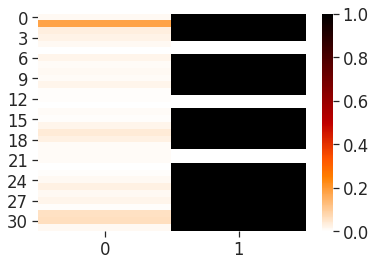

<Figure size 180x432 with 0 Axes>

<AxesSubplot:xlabel='label'>

<AxesSubplot:xlabel='label'>

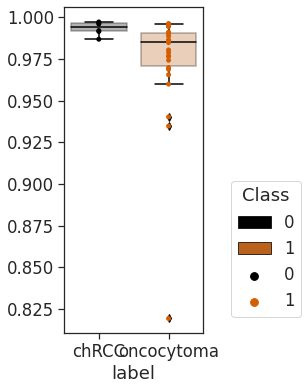

In [131]:
# probabilities for Chopra
model=get_model(0)

predictions = model.predict(data_chopra)
# predictions
probs = model.predict_proba(data_chopra)
# probs

correct_col = np.array(diagnoses_chopra['overallpath']).reshape((-1, 1))
to_plot = np.concatenate([probs[:,1:2], correct_col], axis=1)# plots probability of class 1 (oncocytoma) vs the actual class 1s (oncocytoms)
import seaborn as sb
sb.heatmap(to_plot, cmap='gist_heat_r')
plt.show()

# alteratively, plotting as scatter plot:
# plotting probability of being chRCC (class 0)
plt.figure(figsize=(2.5, 6))
xs = diagnoses_chopra['label']
xs = xs.replace('KICH', 'chRCC')


sb.stripplot(x=xs, y= probs[:,0], order = ['chRCC', 'oncocytoma'], hue=diagnoses_chopra['overallpath'], palette = [ "#000000", "#D55E00"], jitter=0)
sb.boxplot(x=xs, y= probs[:,0], order = ['chRCC', 'oncocytoma'], hue=diagnoses_chopra['overallpath'], boxprops=dict(alpha=.3), dodge=False, palette = [ "#000000", "#D55E00"])
plt.legend(title='Class', bbox_to_anchor=(1.7, 0.05), loc='lower right', borderaxespad=0.)
plt.savefig('figs_hyperparameter_tuning/validation_results/probabilities_for_chRCC_model_0_Chopra.svg', bbox_inches='tight')


<AxesSubplot:>

<Figure size 144x432 with 0 Axes>

<AxesSubplot:xlabel='Sample_Type'>

<AxesSubplot:xlabel='Sample_Type'>

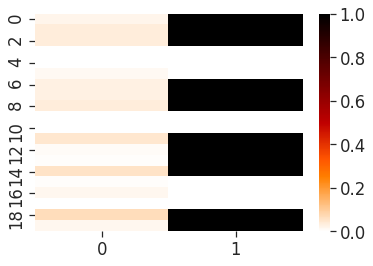

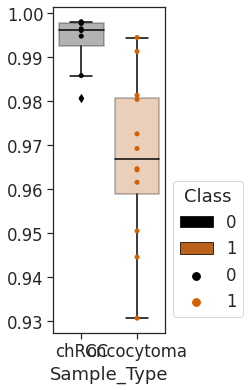

In [137]:
# probabilities for Brennan
model=get_model(0)

predictions = model.predict(data_brennan)
# predictions
probs = model.predict_proba(data_brennan)
# probs

correct_col = np.array(diagnoses_brennan['overallpath']).reshape((-1, 1))
to_plot = np.concatenate([probs[:,1:2], correct_col], axis=1)# plots probability of class 1 (oncocytoma) vs the actual class 1s (oncocytoms)
import seaborn as sb
sb.heatmap(to_plot, cmap='gist_heat_r')

# alteratively, plotting as scatter plot:
# probability of being chRCC
plt.figure(figsize=(2, 6))

xs = diagnoses_brennan['Sample_Type']
xs = xs.replace('Oncocytoma', 'oncocytoma').replace('RCC-Chromophobe', 'chRCC')

sb.stripplot(x=xs, y= probs[:,0], order = ['chRCC', 'oncocytoma'], hue=diagnoses_brennan['overallpath'], palette = [ "#000000", "#D55E00"], jitter=0)
sb.boxplot(x=xs, y= probs[:,0], order = ['chRCC', 'oncocytoma'], hue=diagnoses_brennan['overallpath'], boxprops=dict(alpha=.3), dodge=False, palette = [ "#000000", "#D55E00"])
plt.legend(title='Class', bbox_to_anchor=(1.7, 0.05), loc='lower right', borderaxespad=0.)
plt.savefig('figs_hyperparameter_tuning/validation_results/probabilities_for_chRCC_model_0_Brennan.svg', bbox_inches='tight')


In [99]:
# so using a new manually tuned threshold, the maximum accuracy we can get is:
# for Brennan:
predictions = model.predict(data_brennan)
probs = model.predict_proba(data_brennan)

manual_predictions = probs[:,1] > 0.017

np.mean(manual_predictions == diagnoses_brennan['overallpath'])

confusion_matrix(diagnoses_brennan['overallpath'], manual_predictions)

0.95

array([[ 8,  0],
       [ 1, 11]])

In [69]:
# and for Chopra:
predictions = model.predict(data_chopra)
probs = model.predict_proba(data_chopra)

manual_predictions = probs[:,1] > 0.009 # not perfect, but the ideal threshold is around here
manual_predictions

np.mean(manual_predictions == diagnoses_chopra['overallpath'])

confusion_matrix(diagnoses_chopra['overallpath'], manual_predictions)

array([False,  True,  True, False,  True, False,  True,  True,  True,
       False,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True, False, False, False,  True,  True,  True,
        True,  True,  True,  True, False])

0.6875

array([[ 3,  3],
       [ 7, 19]])